In [87]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nir-generated-answers/generated_results_with_f1_llama2_chegeka.csv
/kaggle/input/nir-generated-answers/ruopenbookqa_gemma_generated_results.csv
/kaggle/input/nir-generated-answers/rudetox-nir (1).ipynb
/kaggle/input/nir-generated-answers/chgk_generated_results_with_f1_mistral.csv
/kaggle/input/nir-generated-answers/ruopenbookqa_vikhr_generated_results.csv
/kaggle/input/nir-generated-answers/Llama2_rutedox_generated_results.csv
/kaggle/input/nir-generated-answers/ruopenbookqa_tinyllama_generated_results.csv
/kaggle/input/nir-generated-answers/ruopenbookqa_mistral_generated_results.csv
/kaggle/input/nir-generated-answers/chgk_generated_results_Gemma.csv
/kaggle/input/nir-generated-answers/chgk_generated_results_tinyLlama.csv
/kaggle/input/nir-generated-answers/rudetox_Vikhr_generated_results.csv
/kaggle/input/nir-generated-answers/rudetox_Mistral_generated_results.csv
/kaggle/input/nir-generated-answers/chgk_generated_results_with_f1_gemma.csv
/kaggle/input/nir-generated-an

In [88]:
!pip -q install shap transformers datasets
!pip install langchain
!pip install langchain
!pip install peft
!pip install trl
!pip install shap

!pip install -q -U transformers
!pip install -q accelerate
!pip install -q -i https://pypi.org/simple/ bitsandbytes
!pip install -q -U datasets
!pip install shap
# !pip install lime
# !pip install lit-nlp

import warnings
warnings.filterwarnings("ignore")


In [89]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

import torch
import torch.nn as nn

import transformers
from transformers import (AutoModelForCausalLM, 
                          AutoTokenizer, 
                          BitsAndBytesConfig, 
                          TrainingArguments, 
                          pipeline, 
                          logging)
from datasets import Dataset
from peft import LoraConfig, PeftConfig
import bitsandbytes as bnb

from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             confusion_matrix)
from sklearn.model_selection import train_test_split
import shap
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re

## Metrics
- Style transfer accuracy (STA) is evaluated with a BERT-based classifier fine-tuned from Conversational Rubert trained on a merge of the Russian Language Toxic Comments dataset collected from 2ch.hk and the Toxic Russian Comments dataset collected from ok.ru.
- Meaning preservation score (SIM) is evaluated as cosine similarity of LaBSE sentence embeddings [4]. For computational optimization, we use the model version, which is the original LaBSE from Google with embeddings for languages other than Russian and English stripped away.
- Fluency score (FL) is evaluated with a fluency classifier. This BERT-based model is trained to distinguish real user-generated texts from corrupted texts. We train the model on 780 thousand texts from Odnoklassniki and Pikabu toxicity datasets and a few [web corpora](https://wortschatz.uni-leipzig.de/en/download) and on their automatically corrupted versions. The corruptions included random replacement, deletion, insertion, shuffling, re-inflection of words and characters, random capitalization changes, round-trip translation, and filling random gaps with T5 and RoBERTA models. We compute the probability of being corrupted for each sentence pair for its source and target sentences. The overall fluency score is the difference between these two probabilities. The rationale behind this is the following. Since we detoxify user-generated sentences, they can already contain errors and disfluencies, and it is unfair to expect a detoxification model to fix these errors. We ensure that the detoxification model produces a text that is not worse in terms of fluency than the original message.
- Joint score: We combine the three metrics to get a single number along which models can be compared. It is computed as an averaged sentence-level multiplication of STA, SIM, and FL:

In [2]:
import pandas as pd

df_gemma = pd.read_csv('/kaggle/input/nir-generated-answers/rudetox_gemma_generated_results (2).csv')
df_mistral = pd.read_csv('/kaggle/input/nir-generated-answers/rudetox_Mistral_generated_results.csv')
df_tinyllama = pd.read_csv('/kaggle/input/nir-generated-answers/TinyLlama_rutedox_generated_results.csv')
df_vikhr = pd.read_csv('/kaggle/input/nir-generated-answers/rudetox_Vikhr_generated_results.csv')
df_llama2 = pd.read_csv('/kaggle/input/nir-generated-answers/Llama2_rutedox_generated_results.csv')

df_mistral.head()


,question,prompt,expected_answer,generated_text
0,"Ну а зачем мне овуляшка, которая свалит в декр...","Есть токсичный ответ: ""Ну а зачем мне овуляшка...","Ну а зачем мне девушка, которая уйдет в декрет...","ну а зачем мне овуляшка, которая свалит в декр..."
1,"Ну а зачем мне овуляшка, которая свалит в декр...","Токсичный ответ: ""Ну а зачем мне овуляшка, кот...","Ну а зачем мне девушка, которая уйдет в декрет...","\n""Ну а зачем мне овуляшка, которая свалит в д..."
2,"Ну а зачем мне овуляшка, которая свалит в декр...","Токсичный комментарий: ""Ну а зачем мне овуляшк...","Ну а зачем мне девушка, которая уйдет в декрет...","\n""Ну а зачем мне овуляшка, которая свалит в д..."
3,"Ну а зачем мне овуляшка, которая свалит в декр...","Токсичное сообщение: ""Ну а зачем мне овуляшка,...","Ну а зачем мне девушка, которая уйдет в декрет...","\n""Ну а зачем мне овуляшка, которая свалит в д..."
4,"Ну а зачем мне овуляшка, которая свалит в декр...","Токсичный ответ: ""Ну а зачем мне овуляшка, кот...","Ну а зачем мне девушка, которая уйдет в декрет...","\n""Ну а зачем мне овуляшка, которая свалит в д..."


# Calculating Metrics

In [6]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel
import torch
from transformers import pipeline

def clean_text(text):
    return text.strip().lower()

# Clean the generated_text column in all dataframes
for df in [df_gemma, df_mistral, df_tinyllama, df_vikhr, df_llama2]:
    df['generated_text'] = df['generated_text'].apply(clean_text)

2024-05-28 20:25:24.731842: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 20:25:24.731940: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 20:25:24.993105: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [13]:
from transformers import BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained('SkolkovoInstitute/russian_toxicity_classifier')
model = BertForSequenceClassification.from_pretrained('SkolkovoInstitute/russian_toxicity_classifier')

def evaluate_style(texts):
    model.eval()
    scores = []
    
    with torch.no_grad():
        for text in texts:
            inputs = tokenizer.encode(text, return_tensors='pt')
            outputs = model(inputs)
            prediction = torch.softmax(outputs.logits, dim=-1)
            scores.append(prediction[0][1].item())
    
    return np.mean(scores)

In [21]:
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity

meaning_tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
meaning_model = BertModel.from_pretrained('bert-base-multilingual-cased')

def get_embeddings(texts):
    inputs = meaning_tokenizer(texts, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = meaning_model(**inputs)
    return outputs.pooler_output

def evaluate_similarity(original_texts, generated_texts):
    original_embeddings = get_embeddings(original_texts)
    generated_embeddings = get_embeddings(generated_texts)
    similarities = cosine_similarity(original_embeddings.numpy(), generated_embeddings.numpy())
    return np.diagonal(similarities).mean()


In [8]:
# model = BertModel.from_pretrained('bert-base-multilingual-cased')
# tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def get_embeddings(texts):
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)

def evaluate_similarity(original_texts, generated_texts):
    original_embeddings = get_embeddings(original_texts)
    generated_embeddings = get_embeddings(generated_texts)
    similarities = cosine_similarity(original_embeddings.numpy(), generated_embeddings.numpy())
    return np.diagonal(similarities).mean()


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [9]:
fluency_classifier = pipeline("text-classification", model="bert-base-cased")

def evaluate_fluency(texts):
    results = fluency_classifier(texts)
    scores = [result['score'] for result in results]
    return np.mean(scores)


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [22]:
# Evaluate each model
def evaluate_model(df):
    original_texts = df['prompt'].tolist()
    generated_texts = df['generated_text'].tolist()
    expected_texts = df['expected_answer'].tolist()

    style_score = evaluate_style(generated_texts)
    similarity_score = evaluate_similarity(expected_texts, generated_texts)
    fluency_score = evaluate_fluency(generated_texts)
    joint_score = style_score * similarity_score * fluency_score

    return {
        "accuracy": style_score,
        "similarity": similarity_score,
        "fluency": fluency_score,
        "joint": joint_score
}

# Collect scores for all models
scores = {
    "gemma": evaluate_model(df_gemma),
    "mistral": evaluate_model(df_mistral),
    "tinyllama": evaluate_model(df_tinyllama),
    "vikhr": evaluate_model(df_vikhr),
    "llama2": evaluate_model(df_llama2)
}

# Print results
for model_name, score in scores.items():
    print(f"{model_name.capitalize()} scores:")
    print(f"  Style Accuracy: {score['accuracy']:.2f}")
    print(f"  Similarity: {score['similarity']:.2f}")
    print(f"  Fluency: {score['fluency']:.2f}")
    print(f"  Joint: {score['joint']:.2f}\n")


Gemma scores:
  Style Accuracy: 0.01
  Similarity: 0.42
  Fluency: 0.57
  Joint: 0.00

Mistral scores:
  Style Accuracy: 0.49
  Similarity: 0.84
  Fluency: 0.60
  Joint: 0.25

Tinyllama scores:
  Style Accuracy: 0.63
  Similarity: 0.81
  Fluency: 0.60
  Joint: 0.30

Vikhr scores:
  Style Accuracy: 0.18
  Similarity: 0.90
  Fluency: 0.59
  Joint: 0.10

Llama2 scores:
  Style Accuracy: 0.49
  Similarity: 0.84
  Fluency: 0.60
  Joint: 0.25



## Plotting the results

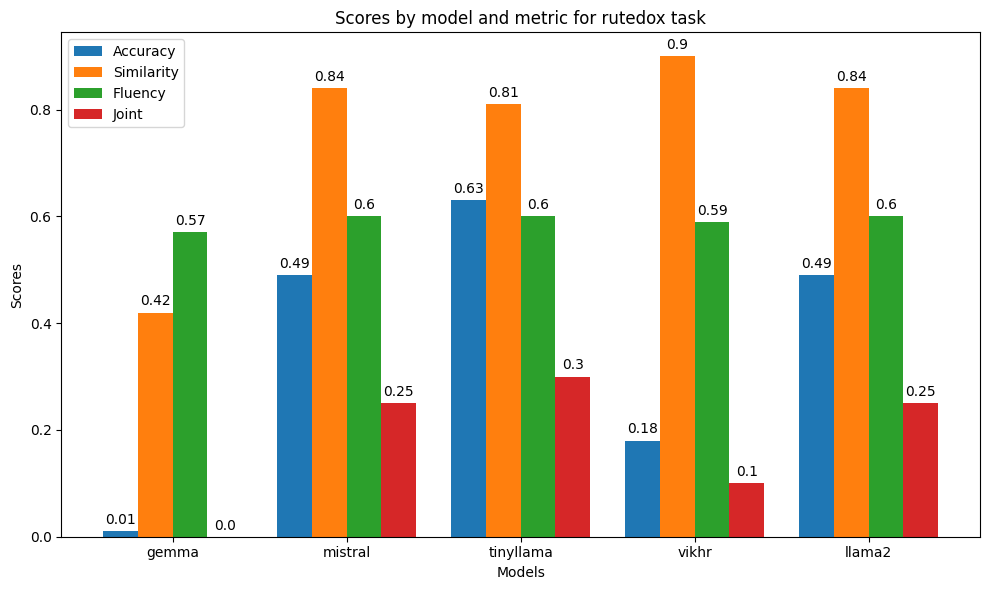

In [24]:
import matplotlib.pyplot as plt

scores = {
    "gemma": {"accuracy": 0.01, "similarity": 0.42, "fluency": 0.57, "joint": 0.00},
    "mistral": {"accuracy": 0.49, "similarity": 0.84, "fluency": 0.60, "joint": 0.25},
    "tinyllama": {"accuracy": 0.63, "similarity": 0.81, "fluency": 0.60, "joint": 0.30},
    "vikhr": {"accuracy": 0.18, "similarity": 0.90, "fluency": 0.59, "joint": 0.10},
    "llama2": {"accuracy": 0.49, "similarity": 0.84, "fluency": 0.60, "joint": 0.25},
}

# Extract the metrics
models = list(scores.keys())
accuracy_scores = [scores[model]['accuracy'] for model in models]
similarity_scores = [scores[model]['similarity'] for model in models]
fluency_scores = [scores[model]['fluency'] for model in models]
joint_scores = [scores[model]['joint'] for model in models]

x = np.arange(len(models))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))

# Bar plots
rects1 = ax.bar(x - 1.5*width, accuracy_scores, width, label='Accuracy')
rects2 = ax.bar(x - 0.5*width, similarity_scores, width, label='Similarity')
rects3 = ax.bar(x + 0.5*width, fluency_scores, width, label='Fluency')
rects4 = ax.bar(x + 1.5*width, joint_scores, width, label='Joint')

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Scores by model and metric for rutedox task')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Adding value labels on the bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)
add_labels(rects3)
add_labels(rects4)

fig.tight_layout()

plt.show()


# Calculating Answer Variability

In [91]:
df_gemma = pd.read_csv('/kaggle/input/nir-generated-answers/rudetox_gemma_generated_results (2).csv')
df_mistral = pd.read_csv('/kaggle/input/nir-generated-answers/rudetox_Mistral_generated_results.csv')
df_tinyllama = pd.read_csv('/kaggle/input/nir-generated-answers/TinyLlama_rutedox_generated_results.csv')
df_vikhr = pd.read_csv('/kaggle/input/nir-generated-answers/rudetox_Vikhr_generated_results.csv')
df_llama2 = pd.read_csv('/kaggle/input/nir-generated-answers/Llama2_rutedox_generated_results.csv')


In [52]:
# This function calculates the mean cosine similarity for all formats of a single question.
from sklearn.feature_extraction.text import CountVectorizer

def calculate_mean_cosine_similarity_for_question(df):
    vectorizer = CountVectorizer(stop_words = None)
    X_generated = vectorizer.fit_transform(df['generated_text'])
    X_prompt = vectorizer.transform(df['prompt'])

    cos_sim_matrix = cosine_similarity(X_generated, X_prompt)
    mean_cosine_similarity = cos_sim_matrix.diagonal().mean()
    
    return mean_cosine_similarity


In [65]:
# This function calculates the mean cosine similarity for all formats of a single question.

def preprocess_text(text):
    text = re.sub(r'\n', '', text)  
    text = text.strip()  
    return text.lower()

def calculate_mean_cosine_similarity_for_question(df):
    vectorizer = CountVectorizer()
    X_generated = vectorizer.fit_transform(df['generated_text'])
    X_prompt = vectorizer.transform(df['prompt'])

    cos_sim_matrix = cosine_similarity(X_generated, X_prompt)
    mean_cosine_similarity = cos_sim_matrix.diagonal().mean()
    
    return mean_cosine_similarity


In [70]:
def calculate_overall_variability(dataframes):
    question_variabilities = []

    for df in dataframes:
        question_ids = df['question'].unique()
        question_means = []

        for question_id in question_ids:
            df_question = df[df['question'] == question_id]
            if df_question.empty:
                continue

            mean_cosine_similarity = calculate_mean_cosine_similarity_for_question(df_question)
            if mean_cosine_similarity is not None:
                question_means.append(mean_cosine_similarity)

        if question_means:
            question_variability = 1 - pd.Series(question_means).mean()
            question_variabilities.append(question_variability)

    overall_variability = pd.Series(question_variabilities).mean()

    return overall_variability


In [77]:
#Calculating Cosine Similarity 

dataframes = [df_gemma, df_mistral, df_tinyllama, df_vikhr, df_llama2]

# variability_gemma = calculate_overall_variability([df_gemma])
variability_mistral = calculate_overall_variability([df_mistral])
variability_tinyllama = calculate_overall_variability([df_tinyllama])
variability_vikhr = calculate_overall_variability([df_vikhr])
variability_llama2 = calculate_overall_variability([df_llama2])

# print("Gemma Answer Variability (Cosine Similarity):", variability_gemma)
print("Mistral Answer Variability (Cosine Similarity):", variability_mistral)
print("Tinyllama Answer Variability (Cosine Similarity):", variability_tinyllama)
print("Vikhr Answer Variability (Cosine Similarity):", variability_vikhr)
print("Llama2 Answer Variability (Cosine Similarity):", variability_llama2)


Mistral Answer Variability (Cosine Similarity): 0.5368048554271185
Tinyllama Answer Variability (Cosine Similarity): 0.6280754376243584
Vikhr Answer Variability (Cosine Similarity): 0.7132166011915092
Llama2 Answer Variability (Cosine Similarity): 0.5368048554271185


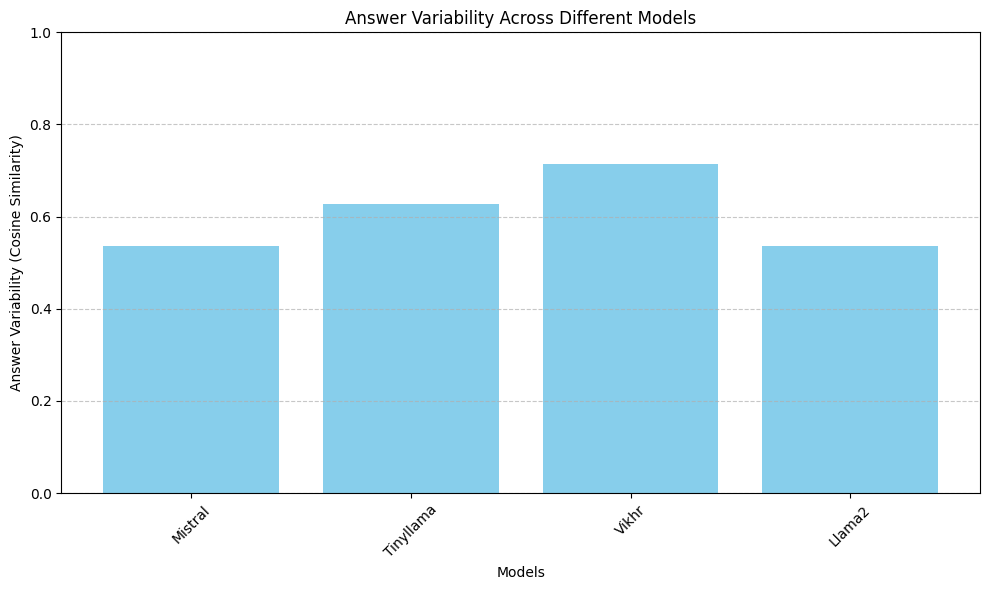

In [82]:
import matplotlib.pyplot as plt

variability_results = {
    "Mistral": 0.5368048554271185,
    "Tinyllama": 0.6280754376243584,
    "Vikhr": 0.7132166011915092,
    "Llama2": 0.5368048554271185
}

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.bar(variability_results.keys(), variability_results.values(), color='skyblue')
plt.xlabel('Models')
plt.ylabel('Answer Variability (Cosine Similarity)')
plt.title('Answer Variability Across Different Models')
plt.ylim(0, 1)  
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# SHAP

In [99]:
from transformers import AutoModelForCausalLM, AutoConfig

model = AutoModelForCausalLM.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0")

config = AutoConfig.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0")

# Set model decoder to true
config.is_decoder = True

# Set text-generation params under task_specific_params
config.task_specific_params = {
    "text-generation": {
        "do_sample": True,
        "max_length": 50,
        "temperature": 0,
        "top_k": 50,
        "no_repeat_ngram_size": 2
    }
}

# Assign the updated configuration to the model
model.config = config


AttributeError: 'LlamaConfig' object has no attribute 'mlp_bias'

In [98]:
tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0")
model = AutoModelForCausalLM.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0")

AttributeError: 'LlamaConfig' object has no attribute 'mlp_bias'

In [93]:
df_tinyllama.head()

,question,prompt,expected_answer,generated_text
0,"Ну а зачем мне овуляшка, которая свалит в декр...","Есть токсичный ответ: ""Ну а зачем мне овуляшка...","Ну а зачем мне девушка, которая уйдет в декрет...","\n""Ну а зачем мне овуляшка, которая свалит в д..."
1,"Ну а зачем мне овуляшка, которая свалит в декр...","Токсичный ответ: ""Ну а зачем мне овуляшка, кот...","Ну а зачем мне девушка, которая уйдет в декрет...","\n""Ну а зачем мне овуляшка, которая свалит в д..."
2,"Ну а зачем мне овуляшка, которая свалит в декр...","Токсичный комментарий: ""Ну а зачем мне овуляшк...","Ну а зачем мне девушка, которая уйдет в декрет...","\n\nОтвет: ""Ну а зачем мне овуляшка, которая с..."
3,"Ну а зачем мне овуляшка, которая свалит в декр...","Токсичное сообщение: ""Ну а зачем мне овуляшка,...","Ну а зачем мне девушка, которая уйдет в декрет...","\n""Ну а зачем мне овуляшка, которая свалит в д..."
4,"Ну а зачем мне овуляшка, которая свалит в декр...","Токсичный ответ: ""Ну а зачем мне овуляшка, кот...","Ну а зачем мне девушка, которая уйдет в декрет...","\n""Ну а зачем мне овуляшка, которая свалит в д..."


In [94]:
x = [
       "Причиной какого явления может быть вырубка леса?\nA. глобальное потепление\nB. гибель океанов\nC. солевые растворы\nD. гибель деревьев\nКакой ответ является правильным? Запишите только букву верного варианта: A, B, C или D.\nОтвет: "
]
     

y = [
    "2. C"
]

In [95]:
teacher_forcing_model = shap.models.TeacherForcing(model, tokenizer)
masker = shap.maskers.Text(tokenizer, mask_token = "...", collapse_mask_token=True)

explainer = shap.Explainer(teacher_forcing_model,masker)
shap_values = explainer(x, y)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
shap.plots.text(shap_values)
